In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt


# Transformation / Preprocessing Work

In [2]:
# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

# Focus only on the final 4 --> Equity Indices, Fixed Income, and Commodities.
binary_df = pd.DataFrame(columns=["Stock", "Bonds", "Commodities"], index=response_df.index)
binary_df['Stock'] = response_df['Equity Indices Market'].apply(lambda x: 1 if x > 0 else 0)
binary_df['Bonds'] = response_df['Fixed Income Market'].apply(lambda x: 1 if x > 0 else 0)
binary_df['Commodities'] = response_df['Commodities Market'].apply(lambda x: 1 if x > 0 else 0)

dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = normalized_df.iloc[:training_ends, :], normalized_df.iloc[training_ends:test_ends, :], normalized_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = binary_df.iloc[:training_ends, :], binary_df.iloc[training_ends:test_ends, :], binary_df.iloc[test_ends:, :]
X_train.shape, X_test.shape, X_analysis.shape

((216, 58), (120, 58), (19, 58))

In [4]:
def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.tight_layout()
    plt.title(title)
    plt.show()

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [6]:
n_steps = 12
cnn_X_train, cnn_y_train = split_sequences(y_train.values, n_steps)
cnn_X_test, cnn_y_test = split_sequences(y_test.values, n_steps)
cnn_X_train.shape, cnn_y_train.shape, cnn_X_test.shape, cnn_y_test.shape

((204, 12, 3), (204, 3), (108, 12, 3), (108, 3))

In [11]:
# Define the MultiSeries CNN problem.
n_features = 3
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(n_features))
model.compile(optimizer='adam', loss='mse', metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 64)            448       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 16,651
Trainable params: 16,651
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 0.3076 - accuracy: 0.2941 - val_loss: 0.2885 - val_accuracy: 0.2500
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2664 - accuracy: 0.1562

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 14ms/step - loss: 0.2623 - accuracy: 0.3137 - val_loss: 0.2469 - val_accuracy: 0.4167
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.2334 - accuracy: 0.4167 - val_loss: 0.2618 - val_accuracy: 0.1852
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2268 - accuracy: 0.2843 - val_loss: 0.2582 - val_accuracy: 0.2315
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.2177 - accuracy: 0.4412 - val_loss: 0.2482 - val_accuracy: 0.4074
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2097 - accuracy: 0.4951 - val_loss: 0.2519 - val_accuracy: 0.3333
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2035 - accuracy: 0.4657 - val_loss: 0.2525 - val_accuracy: 0.3796
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1972 - accuracy: 0.5245 - val_loss: 0.2520 - val_accuracy: 0.3981
Epoch 9/100
7/7 [===============

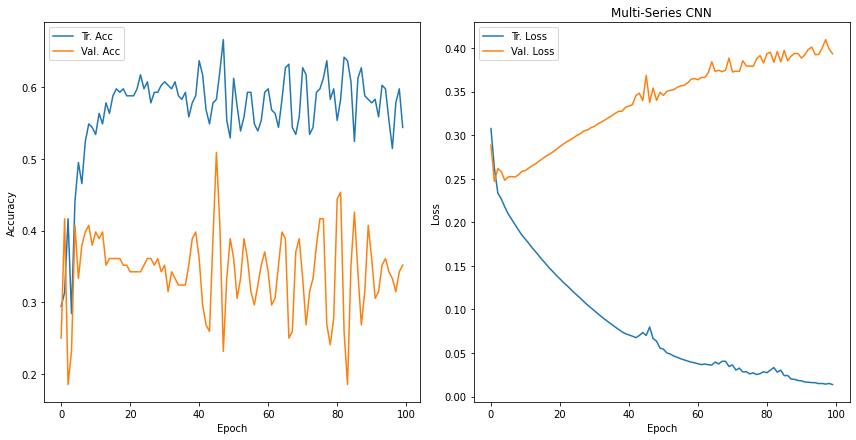

In [12]:
history = model.fit(cnn_X_train, cnn_y_train, epochs=100, validation_data=(cnn_X_test, cnn_y_test), shuffle=False)
graphHistory(history, "Multi-Series CNN")